# Convert DeepLab v3+ EdgeTPUv2 TF-Hub model to ONNX model.

Copyright (c) 2021 Nobuo Tsukamoto  
This software is released under the MIT License.  
See the LICENSE file in the project root for more information.  

This notebook contains steps to convert deeplab-edgetpuv2 and autoseg-edgetpu models to ONNX models. Convert from the TensorFlow Hub Saved Model to the TensorFlow Lite FP32 model and then to the ONNX model.  
After conversion, make inferences with the Saved Model, TensorFlow Lite model, and ONNX model to confirm that the results are the same.

## Reference

- [TensorFlow Hub](https://tfhub.dev/)
    - [deeplab-edgetpu](https://tfhub.dev/google/collections/deeplab-edgetpu/1)
    - [autoseg-edgetpu](https://tfhub.dev/google/collections/autoseg-edgetpu/1)
- [ONNX](https://onnx.ai/)
    - [tf2onnx](https://github.com/onnx/tensorflow-onnx)
    - [ONNX Simplifier](https://github.com/daquexian/onnx-simplifier)

## Imports

In [ ]:
import io
import os
import numpy as np
import requests
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image as PILImage

## Convert Saved model -> TF-Lite -> ONNX

In [ ]:
#@title Select TF-Hub model. { run: "auto" }

model_name = "deeplab-edgetpu_default_argmax_xs" #@param ["deeplab-edgetpu_default_argmax_xs", "deeplab-edgetpu_default_argmax_s", "deeplab-edgetpu_default_argmax_m", "deeplab-edgetpu_fused_argmax_xs", "deeplab-edgetpu_fused_argmax_s", "deeplab-edgetpu_fused_argmax_m", "autoseg-edgetpu_default_argmax_xs", "autoseg-edgetpu_default_argmax_s", "autoseg-edgetpu_fused_argmax_xs", "autoseg-edgetpu_fused_argmax_s"]

In [ ]:
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512

MODEL_URL = {"deeplab-edgetpu_default_argmax_xs":"https://tfhub.dev/google/edgetpu/vision/deeplab-edgetpu/default_argmax/xs/1",
             "deeplab-edgetpu_default_argmax_s":"https://tfhub.dev/google/edgetpu/vision/deeplab-edgetpu/default_argmax/s/1",
             "deeplab-edgetpu_default_argmax_m":"https://tfhub.dev/google/edgetpu/vision/deeplab-edgetpu/default_argmax/m/1",
             "deeplab-edgetpu_fused_argmax_xs":"https://tfhub.dev/google/edgetpu/vision/deeplab-edgetpu/fused_argmax/xs/1",
             "deeplab-edgetpu_fused_argmax_s":"https://tfhub.dev/google/edgetpu/vision/deeplab-edgetpu/fused_argmax/s/1",
             "deeplab-edgetpu_fused_argmax_m":"https://tfhub.dev/google/edgetpu/vision/deeplab-edgetpu/fused_argmax/m/1",
             "autoseg-edgetpu_default_argmax_xs":"https://tfhub.dev/google/edgetpu/vision/autoseg-edgetpu/default_argmax/xs/1",
             "autoseg-edgetpu_default_argmax_s":"https://tfhub.dev/google/edgetpu/vision/autoseg-edgetpu/default_argmax/s/1",
             "autoseg-edgetpu_fused_argmax_xs":"https://tfhub.dev/google/edgetpu/vision/autoseg-edgetpu/fused_argmax/xs/1",
             "autoseg-edgetpu_fused_argmax_s":"https://tfhub.dev/google/edgetpu/vision/autoseg-edgetpu/fused_argmax/s/1"}

### Download saved model from TF-Hub and export TF-Lite FP32 model.

In [ ]:
# Download the model from Tensorflow Hub.
keras_layer = hub.KerasLayer(MODEL_URL[model_name])
model = tf.keras.Sequential([keras_layer])
model.build([None, IMAGE_WIDTH, IMAGE_HEIGHT, 3])

In [ ]:
# Export TensorFlow Lite FP32 model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpd6ma25c6/assets


INFO:tensorflow:Assets written to: /tmp/tmpd6ma25c6/assets


In [ ]:
# Save TF-Lite model.
models_dir = pathlib.Path(os.path.join("/", "content"))
tflite_file_name = model_name + ".tflite"
tflite_file = models_dir/tflite_file_name
tflite_file.write_bytes(tflite_model)

13093480

### Convert ONNX model.

In [ ]:
!pip3 install git+https://github.com/onnx/tensorflow-onnx
!pip3 install onnxruntime
!pip3 install onnx-simplifier

  Cloning https://github.com/onnx/tensorflow-onnx to /tmp/pip-req-build-8y83hn8d
  Running command git clone -q https://github.com/onnx/tensorflow-onnx /tmp/pip-req-build-8y83hn8d
     |████████████████████████████████| 12.7 MB 5.4 MB/s 
  Created wheel for tf2onnx: filename=tf2onnx-1.10.0-py3-none-any.whl size=435729 sha256=5145431e7d142291a983062ac36279943299d93443845e0c137f3e75bb84e27d
  Stored in directory: /tmp/pip-ephem-wheel-cache-es8ybp81/wheels/73/99/8e/3034c9b47124da4ac24a6ea72b8da1be5af878e37c2e953bb3
Successfully built tf2onnx
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0


     |████████████████████████████████| 4.8 MB 5.3 MB/s 
     |████████████████████████████████| 466 kB 5.2 MB/s 
  Created wheel for onnx-simplifier: filename=onnx_simplifier-0.3.6-py3-none-any.whl size=12873 sha256=5c281c5e7768f2a9649fffcfe0fe35aaadffd6969ad6a1634c0e2be4110a3bd2
  Stored in directory: /root/.cache/pip/wheels/0c/47/80/8eb21098e22c19d60b1c14021ee67442b4ad2d7991fdad46ba
Successfully built onnx-simplifier


In [ ]:
tflite_path = os.path.join("/content", tflite_file_name)
onnx_path = os.path.join("/content", model_name + ".onnx")

In [ ]:
!python3 -m tf2onnx.convert \
    --opset 13 \
    --tflite $tflite_path \
    --output $onnx_path \
    --inputs-as-nchw serving_default_keras_layer_input:0 \
    --dequantize

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2021-12-02 11:46:47,443 - INFO - Using tensorflow=2.7.0, onnx=1.10.2, tf2onnx=1.10.0/72d646
2021-12-02 11:46:47,443 - INFO - Using opset <onnx, 13>
2021-12-02 11:46:48,040 - INFO - Optimizing ONNX model
2021-12-02 11:46:49,883 - INFO - After optimization: Cast -4 (4->0), Const -50 (217->167), Identity -1 (1->0), Reshape -17 (18->1), Transpose -316 (345->29)
2021-12-02 11:46:49,926 - INFO - 
2021-12-02 11:46:49,926 - INFO - Successfully converted TensorFlow model /content/deeplab-edgetpu_default_argmax_xs.tflite to ONNX
2021-12-02 11:46:49,926 - INFO - Model inputs: ['serving_default_keras_layer_input:0']
2021-12-02 11:46:49,926 - INFO - Model outputs: ['StatefulPartitionedCall:0']
2021-12-02 11:46:49,926 - INFO - ONNX model is saved at /content/deepla

In [ ]:
!python3 -m onnxsim \
    $onnx_path \
    $onnx_path \
    --input-shape="serving_default_keras_layer_input:0":1,3,512,512 

Simplifying...
Note: The input shape of the simplified model will be overwritten by the value of '--input-shape' argument. Pass '--dynamic-input-shape' if it is not what you want. Run 'python3 -m onnxsim -h' for details.
Checking 0/3...
Checking 1/3...
Checking 2/3...
Ok!


## Inference

### Common Functions

In [ ]:
def create_label_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    ind = np.arange(256, dtype=np.uint8)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    return colormap

In [ ]:
def label_to_color_image(colormap, label):
    return colormap[label]

In [ ]:
def plt_segmantation_image(input_image, seg_map):
    # Output segmantation image.
    seg_image = label_to_color_image(colormap, seg_map[0])
    seg_pil_image = PILImage.fromarray(seg_image)

    crop_image = input_image.crop((0, 0, IMAGE_WIDTH, IMAGE_HEIGHT))
    image = PILImage.blend(crop_image, seg_pil_image, 0.5)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)

In [ ]:
colormap = create_label_colormap()

### Inference with saved model

In [ ]:
# Preprocess image.
image_url = "https://storage.googleapis.com/tf_model_garden/models/edgetpu/images/ADE_train_00016869.jpeg"
image_response = requests.get(image_url)
image = PILImage.open(io.BytesIO(image_response.content)).convert('RGB')

min_dim = min(image.size[0], image.size[1])
resized_image = image.resize((IMAGE_WIDTH * image.size[0] // min_dim,
                              IMAGE_HEIGHT * image.size[1] // min_dim))
input_data = np.expand_dims(resized_image, axis=0)
input_data = input_data[:, :IMAGE_WIDTH,:IMAGE_HEIGHT, :]
input_data = input_data.astype(np.float) / 128 - 0.5

In [ ]:
# Run segmentation.
output_data = model(input_data)
assert(output_data.numpy().shape == (1, 512, 512))

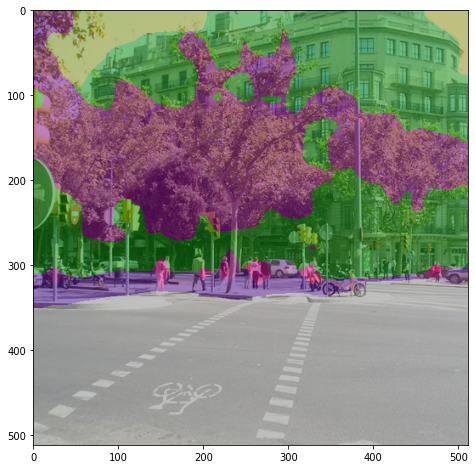

In [ ]:
plt_segmantation_image(resized_image, output_data.numpy().astype(np.uint8))

### Inference with TensorFlow Lite Model

In [ ]:
interpreter = tf.lite.Interpreter(tflite_path)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(interpreter.get_input_details()[0]["index"], input_data.astype('float32'))
interpreter.invoke()
output = interpreter.get_tensor(output_index)

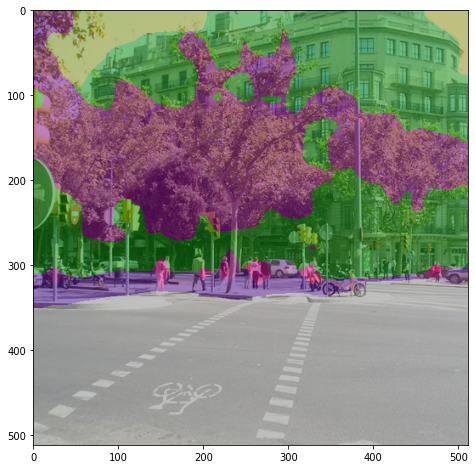

In [ ]:
plt_segmantation_image(resized_image, output.astype(np.uint8))

### Inference with ONNX model

In [ ]:
import onnxruntime

In [ ]:
session = onnxruntime.InferenceSession(onnx_path)

ort_inputs = {session.get_inputs()[0].name: input_data.transpose(0, 3, 1, 2).astype('float32')}
outputs = session.run(None, ort_inputs)

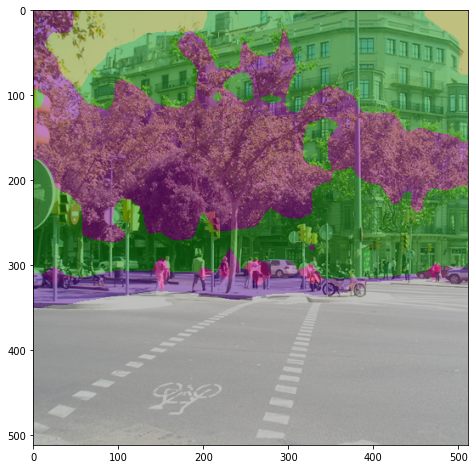

In [ ]:
output = np.array(outputs[0])
plt_segmantation_image(resized_image, output.astype(np.uint8))